In [5]:
from arango import ArangoClient
import nx_arangodb as nxadb

[20:57:29 +0300] [INFO]: NetworkX-cuGraph is unavailable: No module named 'cupy'.


In [2]:
import ifcopenshell
ifc_file = ifcopenshell.open("Ifc4_SampleHouse.ifc")

In [ ]:
import networkx as nx
import itertools

# Create a directed graph
graph = nx.Graph()
all_types = [ifc_file.by_type(name) for name in ifc_file.types()]

merged = list(itertools.chain(*all_types)) 
merged.sort(key=lambda x: x.id())



#print(ifc_file.get_inverse(merged[0]))

for i in range(5):
    print(merged[i])
    print(ifc_file.get_inverse(merged[i]))
    #print(merged[i].get_info())


# Iterate through all elements
for element in merged[:100]:
    # Add the element as a node
    graph.add_node((element.id(),), type= element.get_info())

    for i in ifc_file.get_inverse(element):
        graph.add_edge(i.id(),element.id(),type="inverse")

    """ # Handle relationships
    if hasattr(element, "ContainedInStructure"):
        for rel in element.ContainedInStructure:
            if hasattr(rel, "RelatingStructure"):
                relating_structure = rel.RelatingStructure
                graph.add_edge(element.id(), relating_structure.id(), type=rel.is_a()) """

    """ if hasattr(element, "Decomposes"):
        for rel in element.Decomposes:
            if hasattr(rel, "RelatingObject"):
                relating_object = rel.RelatingObject
                graph.add_edge(element.id(), relating_object.id(), type=rel.is_a())

    if hasattr(element, "IsDecomposedBy"):
        for rel in element.IsDecomposedBy:
            if hasattr(rel, "RelatedObjects"):
                for related_object in rel.RelatedObjects:
                    graph.add_edge(rel.RelatingObject.id(), related_object.id(), type=rel.is_a())

    if hasattr(element, "IsNestedBy"):
        for rel in element.IsNestedBy:
            if hasattr(rel, "RelatedObjects"):
                for related_object in rel.RelatedObjects:
                    graph.add_edge(rel.RelatingObject.id(), related_object.id(), type=rel.is_a())

    if hasattr(element, "Nests"):
        for rel in element.Nests:
            if hasattr(rel, "RelatedObjects"):
                for related_object in rel.RelatedObjects:
                    graph.add_edge(element.id(), related_object.id(), type=rel.is_a()) """

#1=IfcOrganization($,'Autodesk Revit 2015 (ENU)',$,$,$)
{#5=IfcApplication(#1,'2015','Autodesk Revit 2015 (ENU)','Revit')}
#5=IfcApplication(#1,'2015','Autodesk Revit 2015 (ENU)','Revit')
{#42=IfcOwnerHistory(#39,#5,$,.NOCHANGE.,$,$,$,1418982422)}
#6=IfcCartesianPoint((0.,0.,0.))
{#2759=IfcAxis2Placement3D(#6,$,$), #2453=IfcCartesianTransformationOperator3D($,$,#6,1.,$), #83722=IfcAxis2Placement3D(#6,$,$), #77489=IfcAxis2Placement3D(#6,$,$), #36574=IfcPolyLoop((#36555,#6,#36546,#36544)), #4297=IfcAxis2Placement3D(#6,$,$), #83658=IfcAxis2Placement3D(#6,#16,#20), #2710=IfcAxis2Placement3D(#6,$,$), #3093=IfcAxis2Placement3D(#6,$,$), #33318=IfcAxis2Placement3D(#6,$,$), #38365=IfcAxis2Placement3D(#6,$,$), #38486=IfcAxis2Placement3D(#6,$,$), #128=IfcAxis2Placement3D(#6,$,$), #139=IfcAxis2Placement3D(#6,$,$), #37625=IfcAxis2Placement3D(#6,$,$), #3095=IfcAxis2Placement3D(#6,$,$), #83620=IfcAxis2Placement3D(#6,#16,#20), #3251=IfcAxis2Placement3D(#6,$,$), #83730=IfcAxis2Placement3D(#6,#16,#20), 

Graph with 248 nodes and 323 edges


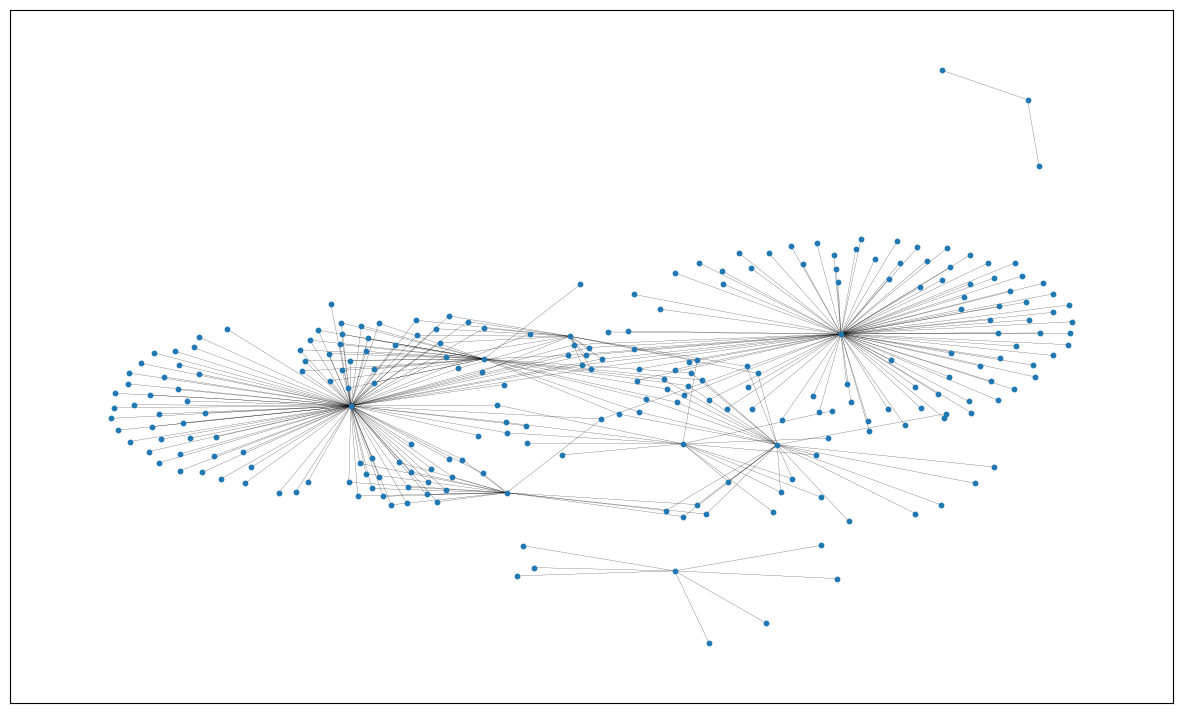

In [72]:
import matplotlib.pyplot as plt

print(graph)

plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
pos = nx.spring_layout(graph, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
nx.draw_networkx(graph, pos=pos, ax=ax, **plot_options)

In [4]:
products = ifc_file.by_type("IfcProduct")
print (products)

[#33688=IfcCovering('3cUkl32yn9qRSPvBJVyWfu',#42,'Compound Ceiling:Plain:286319',$,'Compound Ceiling:Plain',#33652,#33685,'286319',.CEILING.), #33815=IfcCovering('3cUkl32yn9qRSPvBJVyWfk',#42,'Compound Ceiling:Plain:286329',$,'Compound Ceiling:Plain',#33796,#33812,'286329',.CEILING.), #33881=IfcCovering('3cUkl32yn9qRSPvBJVyWgM',#42,'Compound Ceiling:Plain:286337',$,'Compound Ceiling:Plain',#33862,#33878,'286337',.CEILING.), #2375=IfcCurtainWall('3cUkl32yn9qRSPvBJVyW_P',#42,'Curtain Wall:Curtain_Wall-Exterior_Glazing:285582',$,'Curtain Wall:Curtain_Wall-Exterior_Glazing:29096',#2374,$,'285582',$), #3818=IfcCurtainWall('3cUkl32yn9qRSPvBJVyW$Z',#42,'Curtain Wall:Curtain_Wall-Exterior_Glazing:285684',$,'Curtain Wall:Curtain_Wall-Exterior_Glazing:29096',#3817,$,'285684',$), #10993=IfcDoor('3cUkl32yn9qRSPvBJVyWYp',#42,'Doors_ExtDbl_Flush:1810x2110mm:285860',$,'1810x2110mm',#83613,#10986,'285860',2110.,1810.,.DOOR.,.DOUBLE_DOOR_SINGLE_SWING.,$), #21827=IfcDoor('3cUkl32yn9qRSPvBJVyWaG',#42,'Doo

In [2]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()


os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

llm.invoke("hello!")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-9203c787-312a-4da8-962c-cc7eaeed4dee-0', usage_metadata={'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [95]:
import gradio as gr

def greet(name, intensity):
    return "Hello, " + name + "!" * int(intensity)

demo = gr.Interface(
    fn=greet,
    inputs=["text", "slider"],
    outputs=["text"],
)

demo.launch()


c:\Users\Teddy\Documents\vs_code\competition\arangodb-hack\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [94]:
graph.nodes[42]

{'type': {'id': 42,
  'type': 'IfcOwnerHistory',
  'OwningUser': #39=IfcPersonAndOrganization(#36,#38,$),
  'OwningApplication': #5=IfcApplication(#1,'2015','Autodesk Revit 2015 (ENU)','Revit'),
  'State': None,
  'ChangeAction': 'NOCHANGE',
  'LastModifiedDate': None,
  'LastModifyingUser': None,
  'LastModifyingApplication': None,
  'CreationDate': 1418982422}}